# Initial Setup

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


## Check GPU availability

In [ ]:
import tensorflow as tf
print("GPUs available:", tf.config.list_physical_devices('GPU'))


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Download the dataset

In [ ]:
! pip install opendatasets

In [ ]:
# Download the dataset directly drom Kaggle
# You don't need to upload it from the device or the drive
import opendatasets as od
od.download('https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data')

## Import libraries and tools

In [ ]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 6.8 MB/s eta 0:00:00


In [ ]:
import os
from pathlib import Path
import json
from datetime import datetime

import numpy as np
import pandas as pd

import random
from sklearn.utils import shuffle

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import layers, models

import keras_tuner as kt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from sklearn.metrics import confusion_matrix, classification_report


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import sys
from IPython.display import clear_output
from tensorflow.keras.utils import load_img

import warnings
warnings.filterwarnings("ignore")

# Load the Datasets


In [ ]:
# Directories for training and testing data
train_dir = '/content/brain-tumor-mri-dataset/Training'
test_dir = '/content/brain-tumor-mri-dataset/Testing'

In [ ]:
# Extract class labels from the training folder
classes = []
for label in os.listdir(train_dir):
    classes.append(label)

print(f"All classes : {classes}")

All classes : ['pituitary', 'meningioma', 'glioma', 'notumor']


## Combine the training and testing datasets

In [ ]:
def make_dataframe(base_path):
    data = []
    for label in os.listdir(base_path):
        label_folder = os.path.join(base_path, label)
        if os.path.isdir(label_folder):
            for file in os.listdir(label_folder):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    data.append({
                        "image_path": os.path.join(label_folder, file),
                        "label": label.strip().lower()
                    })
    return pd.DataFrame(data)

# Combine training + testing data
df_train = make_dataframe(train_dir)
df_test  = make_dataframe(test_dir)
df = pd.concat([df_train, df_test], ignore_index=True)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
print("Total shape:", df.shape)
print(df['label'].value_counts())

Train shape: (5712, 2)
Test shape: (1311, 2)
Total shape: (7023, 2)
label
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


# Inspect Data Distribution and Samples

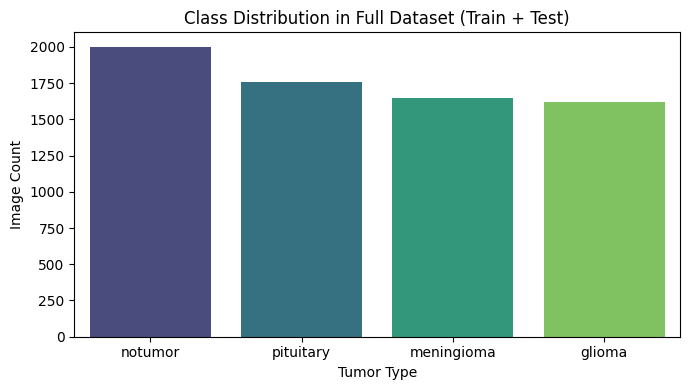

In [ ]:

plt.figure(figsize=(7,4))
sns.countplot(x='label', data=df, palette='viridis', order=df['label'].value_counts().index)
plt.title("Class Distribution in Full Dataset (Train + Test)")
plt.xlabel("Tumor Type")
plt.ylabel("Image Count")
plt.tight_layout()
plt.show()

## Percentage of tumor an no tumor classes

In [ ]:
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'notumor' else 1)

binary_counts = df['binary_label'].value_counts(normalize=True) * 100
non_tumor_pct = binary_counts.get(0, 0)
tumor_pct     = binary_counts.get(1, 0)

print(f"\n{non_tumor_pct:.1f}% of data belongs to Non-Tumor (0)")
print(f"{tumor_pct:.1f}% of data belongs to Tumor (1)")


28.5% of data belongs to Non-Tumor (0)
71.5% of data belongs to Tumor (1)


## Inspect the training data

In [ ]:
# Automatically count images per class folder
train_counts = {}
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        train_counts[class_name] = count
df_train_counts = pd.DataFrame(list(train_counts.items()), columns=["Class", "Image Count"])
df_train_counts["Percentage"] = (df_train_counts["Image Count"] / df_train_counts["Image Count"].sum()) * 100

# Display results
print("=== Training Data Class Distribution ===")
print(df_train_counts)
print(f"\nTotal training images: {df_train_counts['Image Count'].sum()}")

=== Training Data Class Distribution ===
        Class  Image Count  Percentage
0      glioma         1321   23.126751
1  meningioma         1339   23.441877
2     notumor         1595   27.923669
3   pituitary         1457   25.507703

Total training images: 5712


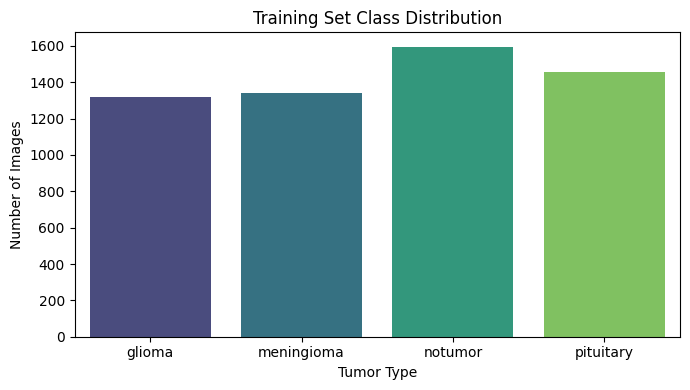

In [ ]:
plt.figure(figsize=(7,4))
sns.barplot(x="Class", y="Image Count", data=df_train_counts, palette="viridis")
plt.title("Training Set Class Distribution")
plt.xlabel("Tumor Type")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

## Visualize sample images

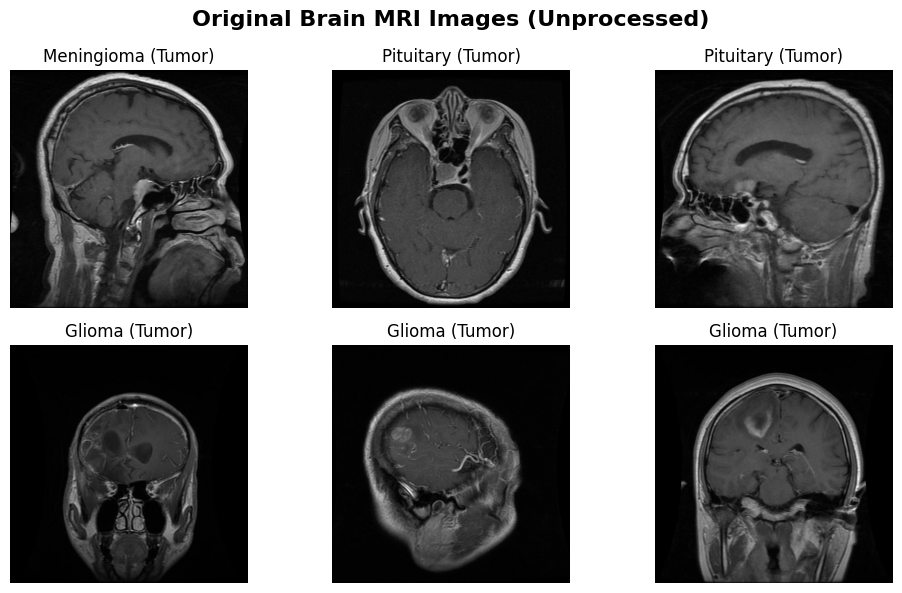

In [ ]:
plt.figure(figsize=(10, 6))
samples = df.sample(6, random_state=42).reset_index(drop=True)

for i, row in samples.iterrows():
    img = Image.open(row['image_path'])
    plt.subplot(2, 3, i + 1)
    plt.imshow(img, cmap='gray')  # Show raw grayscale pixels (no color enhancement)
    plt.title(f"{row['label'].capitalize()} (Tumor)" if row['binary_label'] == 1 else "Non-Tumor")
    plt.axis("off")

plt.suptitle("Original Brain MRI Images (Unprocessed)", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Image preprocessing

## Defining parameters (constants)

In [ ]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2  # 20% of the data for validation
SEED = 42

## Create data generators

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values
    validation_split=0.2  # Reserve 20% for validation
)

# Test data generator — only rescaling
test_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create train generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',   # Multi-class classification
    subset='training',          # Use 80% of training data
    shuffle=True,
    seed=SEED,
    color_mode='rgb'            # Convert grayscale → RGB for pretrained CNNs
)

# Create validation generator (20% of training data)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',        # 20% validation split
    shuffle=False,
    seed=SEED,
    color_mode='rgb'
)

# Create test generator (no subset, only testing images)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)

print("\n=== DATA GENERATORS READY ===")
print(f"✓ Training samples:   {train_generator.samples}")
print(f"✓ Validation samples: {validation_generator.samples}")
print(f"✓ Testing samples:    {test_generator.samples}")
print(f"✓ Class indices:      {train_generator.class_indices}")

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.

=== DATA GENERATORS READY ===
✓ Training samples:   4571
✓ Validation samples: 1141
✓ Testing samples:    1311
✓ Class indices:      {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## Verify preprocessing


=== SAMPLE BATCH INFO ===
Batch shape        : (32, 224, 224, 3)
Labels shape       : (32, 4)
Pixel value range  : [0.000, 1.000]
Data type          : float32

✓ Preprocessed images saved as 'preprocessed_images.png'


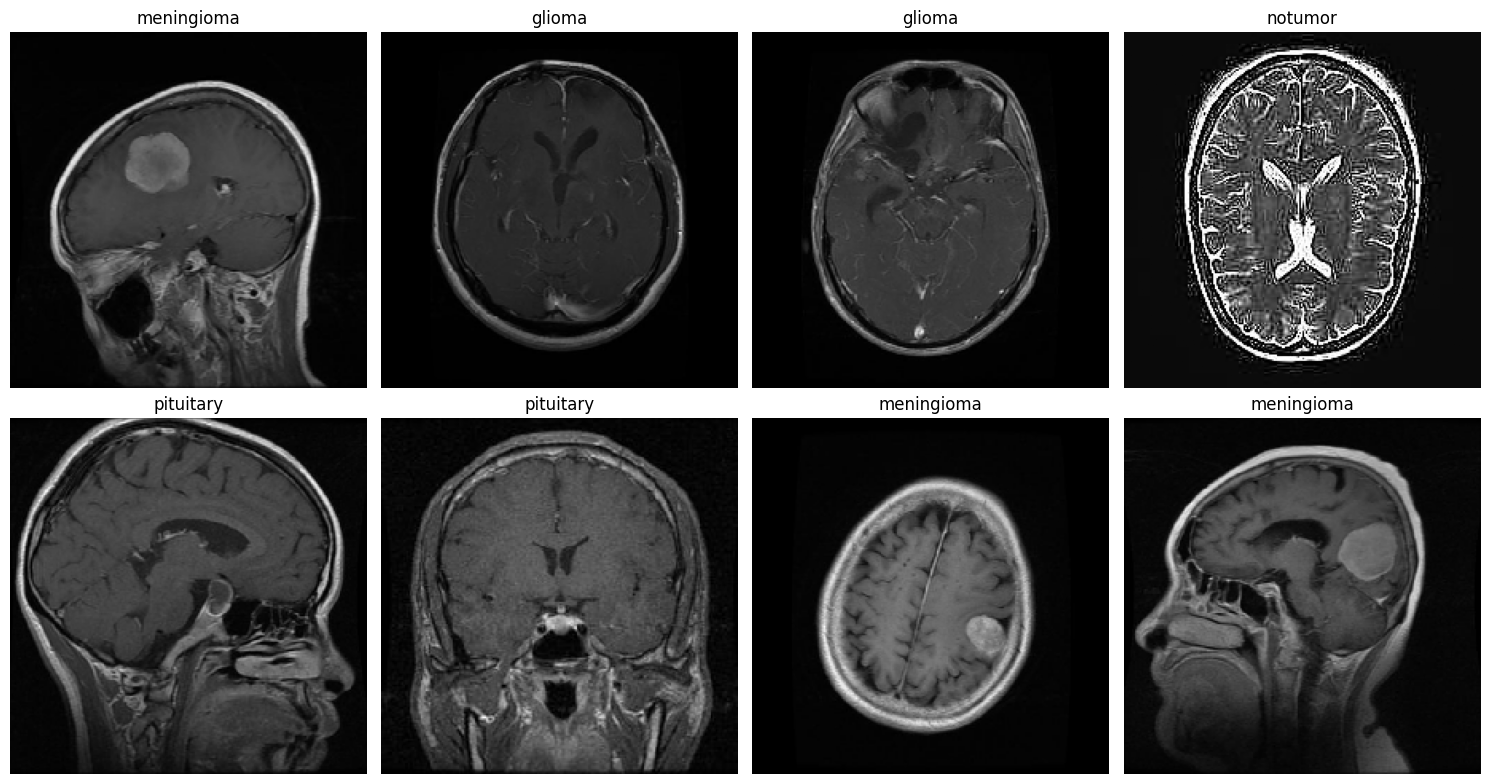

In [ ]:
sample_batch, sample_labels = next(train_generator)

# Display shapes and normalization info
print("\n=== SAMPLE BATCH INFO ===")
print(f"Batch shape        : {sample_batch.shape}")   # (batch_size, 224, 224, 3)
print(f"Labels shape       : {sample_labels.shape}")  # (batch_size, 4)
print(f"Pixel value range  : [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
print(f"Data type          : {sample_batch.dtype}")

# Visualize first 8 preprocessed images
fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.ravel()

for i in range(8):
    axes[i].imshow(sample_batch[i])  # already normalized (0–1) RGB
    class_idx = np.argmax(sample_labels[i])  # get class index
    class_name = list(train_generator.class_indices.keys())[class_idx]
    axes[i].set_title(f"{class_name}")
    axes[i].axis("off")

plt.tight_layout()
plt.savefig("preprocessed_images.png", dpi=150, bbox_inches="tight")
print("\nPreprocessed images saved as 'preprocessed_images.png'")
plt.show()

## Check if it is rgb-compatible

ResNet50 must be fed rgb-encoded images

In [ ]:
# Pick one sample
img = sample_batch[0]

# Compare the three channels
same_channels = np.allclose(img[...,0], img[...,1]) and np.allclose(img[...,1], img[...,2])
print("All three RGB channels identical?", same_channels)


All three RGB channels identical? True


# Creating training and validation datasets

## Define constants

In [ ]:
# Parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2  # 20% of the data for validation
SEED = 42

In [ ]:
# Create training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=32
)

# Create validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=42,
    image_size=IMAGE_SIZE,
    batch_size=32,
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


## Visualizing distributions in training and validation sets

In [ ]:
class_names = train_ds.class_names
print("Classes:", class_names)

Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Save the classnames in order into JSON file for deployment

In [ ]:
save_path = "/content/class_names.json"

with open(save_path, "w") as f:
    json.dump(class_names, f, indent=2)

print("class_names.json created! Location :", save_path)
print(class_names)

class_names.json created! Location : /content/class_names.json
['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# Initialize counters
train_class_counts = np.zeros(len(class_names))
val_class_counts = np.zeros(len(class_names))

# Count training samples
for _, labels in train_ds.unbatch():
    train_class_counts[labels.numpy()] += 1

# Count validation samples
for _, labels in val_ds.unbatch():
    val_class_counts[labels.numpy()] += 1

# Print results
print("Training set class distribution:")
for i, name in enumerate(class_names):
    print(f"{name}: {int(train_class_counts[i])} ({round(int(train_class_counts[i]) / train_class_counts.sum() * 100, 2)}%)")

print("\nValidation set class distribution:")
for i, name in enumerate(class_names):
    print(f"{name}: {int(val_class_counts[i])} ({round(int(val_class_counts[i]) / val_class_counts.sum() * 100, 2)}%)")


Training set class distribution:
glioma: 1077 (23.57%)
meningioma: 1090 (23.85%)
notumor: 1247 (27.29%)
pituitary: 1156 (25.3%)

Validation set class distribution:
glioma: 244 (21.37%)
meningioma: 249 (21.8%)
notumor: 348 (30.47%)
pituitary: 301 (26.36%)


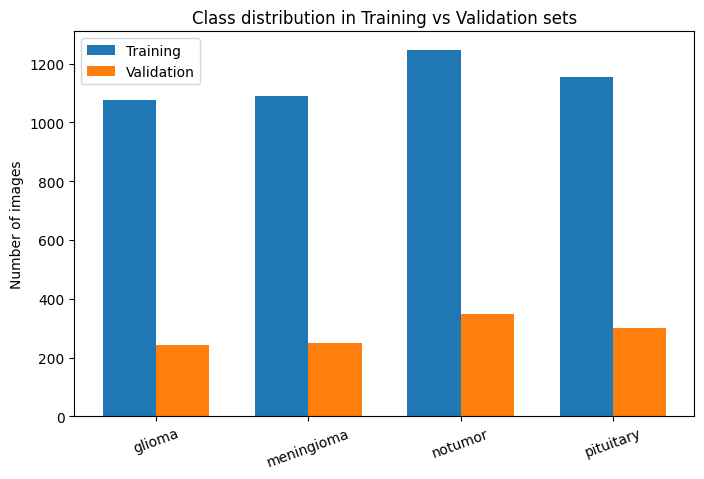

In [ ]:
x = np.arange(len(class_names))
width = 0.35  # width of the bars

plt.figure(figsize=(8,5))
plt.bar(x - width/2, train_class_counts, width, label='Training')
plt.bar(x + width/2, val_class_counts, width, label='Validation')
plt.xticks(x, class_names, rotation=20)
plt.ylabel("Number of images")
plt.title("Class distribution in Training vs Validation sets")
plt.legend()
plt.show()


## Visualize samples of the training data

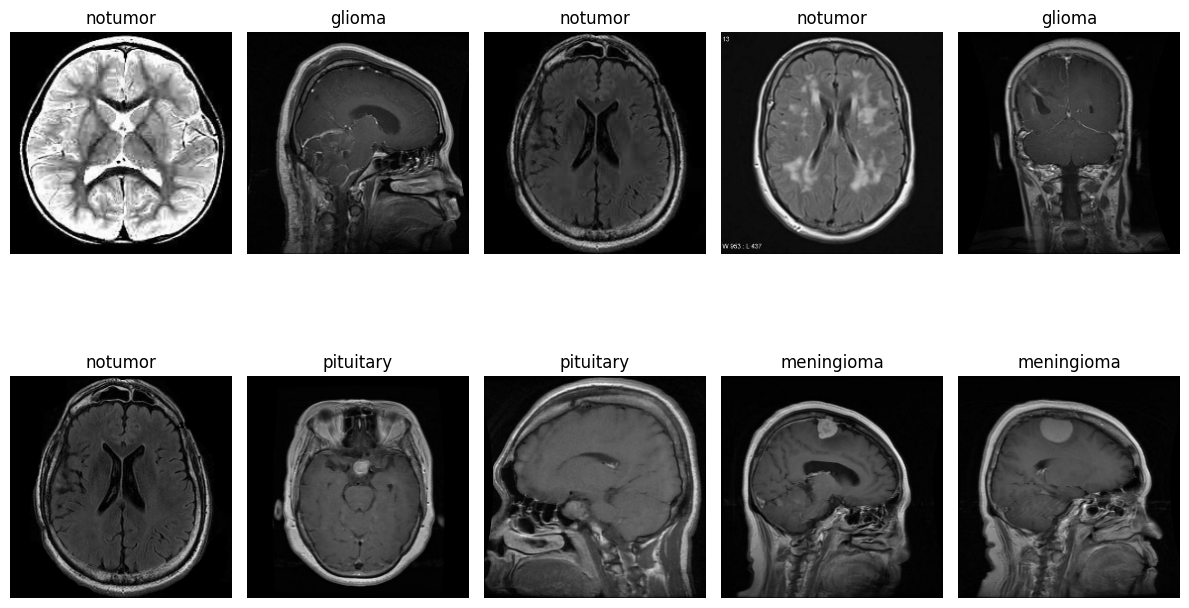

In [ ]:
# Take one batch of images and labels from the dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 8))

    # Show first 10 images from the batch
    for i in range(10):
        # Original image
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"{class_names[labels[i]]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Prefetch and Optimize Loading

prefetching improves performance by overlapping preprocessing and training.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)


# Create the testing dataset

In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(224, 224),     # Same size used in training
    batch_size=32,             # Any batch size
    shuffle=False              # VERY IMPORTANT!!
)

Found 1311 files belonging to 4 classes.


In [ ]:
class_names = test_ds.class_names
print("Class names:", class_names)


Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']


# Classififcation report and the confusion matrix

In [ ]:
def show_classification_report_confusion_matrix(model, test_ds, class_names):
  y_true = []
  for _, labels in test_ds.unbatch():
      y_true.append(labels.numpy())
  y_true = np.array(y_true)

  y_pred = model.predict(test_ds)
  y_pred = np.argmax(y_pred, axis=1)

  print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
  ))

  cm = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
              xticklabels=class_names,
              yticklabels=class_names)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.title("Confusion Matrix on Test Set")
  plt.show()


# Phase 1: Training a baseline CNN

## Use a function to experiment with different models

In [ ]:
num_classes = len(class_names)

### The function that builds the model

Create a function to automate experimenting with different CNN architecture

It takes the number of classes, whether to use augmentation, the augmentation layer and the learning rate.

In [ ]:
def build_cnn_model(num_classes,
                    use_augmentation=True,
                    augmentation_layers=None,
                    learning_rate=1e-4):

    if use_augmentation:
        if augmentation_layers is None:
            augmentation_layers = keras.Sequential([
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.02),
                layers.RandomZoom(0.05),
            ], name="default_augmentation")
    else:
        # Adding an identity layer
        augmentation_layers = keras.Sequential([layers.Lambda(lambda x: x)], name="no_augmentation")

    # Construct the model
    model = models.Sequential([
        # Data Augmentation & Normalization
        layers.Input(shape=(224, 224, 3)),
        augmentation_layers,
        layers.Rescaling(1./255),

        # --- Convolutional Base ---
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),

        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


### Utility functions

In [ ]:
def create_experiment_folder(experiment_name):
    base_path = "/content/drive/MyDrive/Brain_Tumor_Project/experiments"
    exp_path = os.path.join(base_path, experiment_name)
    os.makedirs(exp_path, exist_ok=True)

    return exp_path

def save_experiment_config(exp_path, experiment_name, use_augmentation, learning_rate, epochs):
    config = {
        "experiment": experiment_name,
        "use_augmentation": use_augmentation,
        "learning_rate": learning_rate,
        "epochs": epochs,
        "timestamp": datetime.now().isoformat()
    }
    with open(os.path.join(exp_path, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

def save_training_curves(exp_path, experiment_name, history):
    plot_path = os.path.join(exp_path, "training_plot.png")
    plot_accuracy_and_loss(history, experiment_name)
    plt.savefig(plot_path)
    plt.close()

def save_experiment_history(exp_path, history):
    with open(os.path.join(exp_path, "history.json"), "w") as f:
      json.dump(history.history, f, indent=4)

def save_final_model(exp_path, model):
    final_path = os.path.join(exp_path, "final_model.keras")
    model.save(final_path)

In [ ]:
def plot_accuracy_and_loss(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,5))
    # plt.title(title, fontsize=16, fontweight='bold')

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()

In [ ]:
def final_evaluation(model):
  val_loss, val_acc = model.evaluate(val_ds)
  print(f"Validation Accuracy: {val_acc:.4f}")

### A function to run the experiments

In [ ]:
def run_experiment(experiment_name,
                   num_classes,
                   train_ds,
                   val_ds,
                   use_augmentation=True,
                   augmentation_layers=None,
                   learning_rate=1e-4,
                   epochs=30):

    # Create experiment folder
    exp_path = create_experiment_folder(experiment_name)

    # Save experiment config
    save_experiment_config(exp_path, experiment_name, use_augmentation, learning_rate, epochs)


    # Build model
    model = build_cnn_model(
        num_classes=num_classes,
        use_augmentation=use_augmentation,
        augmentation_layers=augmentation_layers,
        learning_rate=learning_rate
    )
    model.summary()


    # Callbacks
    checkpoint_path = os.path.join(exp_path, "best_model.keras")

    callbacks = [
        # Stops training automatically when the model stops improving — to prevent overfitting and save time.
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),

        # Avoids overshooting & helps model converge smoothly by dynamically changing the learning rate
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),

        # save the best performing version
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
    ]


    # Train model
    print(f"--------Training {experiment_name}...---------")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks
    )
    print(f"--------Training {experiment_name} completed!---------")


    # Save training curves
    save_training_curves(exp_path, experiment_name, history)

    # Save history values
    save_experiment_history(exp_path, history)


    # Save final model
    save_final_model(exp_path, model)
    print(f"Results saved in: {exp_path}")

    return model, history


## I. Training a baseline CNN model before data augmentation

### A. First CNN experiment without augmentation and using GlobalAveragePooling

No augmentation layer is used and the GlobalAveragePooling is used as the final layer of the convolutional base.

We won't be using the previously defined function to run the experiment because the architecture has a slight change.

#### Building the model

In [ ]:
baseline_cnn = models.Sequential([
    # Data Augmentation & Normalization
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),

    # --- Convolutional Base ---
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # --- Dense Head ---
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

baseline_cnn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
baseline_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


#### Training the model

In [ ]:
callbacks = [
    # Stops training automatically when the model stops improving — to prevent overfitting and save time.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    # Avoids overshooting & helps model converge smoothly by dynamically changing the learning rate
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    # save the best performing version
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Brain_Tumor_Project/notebook/baseline_cnn_best.keras", save_best_only=True)
]

history = baseline_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 31s 120ms/step - accuracy: 0.6334 - loss: 0.9304 - val_accuracy: 0.2745 - val_loss: 1.6488 - learning_rate: 1.0000e-04
Epoch 2/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.7744 - loss: 0.6171 - val_accuracy: 0.3248 - val_loss: 1.6729 - learning_rate: 1.0000e-04
Epoch 3/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8218 - loss: 0.5000
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 71ms/step - accuracy: 0.8218 - loss: 0.4998 - val_accuracy: 0.3026 - val_loss: 3.4296 - learning_rate: 1.0000e-04
Epoch 4/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.8545 - loss: 0.4090 - val_accuracy: 0.3084 - val_loss: 2.8189 - learning_rate: 5.0000e-05
Epoch 5/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.8613 - loss: 0.3900 - val_accuracy: 0.7629 - val_loss: 0.6041 - learning_rate: 5.0000e-05
Epoch 6/30
152/152 ━━━━━━━━━━━━━━━━━━━━ 16s 70ms/step - a

#### Visualize metrics

In [ ]:
plot_accuracy_and_loss(history, "Baseline CNN without Augmentation")


In [ ]:
final_evaluation(baseline_cnn)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9016 - loss: 0.2434
Validation Accuracy: 0.9194


In [ ]:
cnn_model = keras.models.load_model("/content/drive/MyDrive/Brain_Tumor_Project/notebook/baseline_cnn_final.keras")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step
              precision    recall  f1-score   support

      glioma       0.95      0.83      0.88       300
  meningioma       0.80      0.70      0.75       306
     notumor       0.86      0.99      0.92       405
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.88      1311
weighted avg       0.88      0.88      0.88      1311



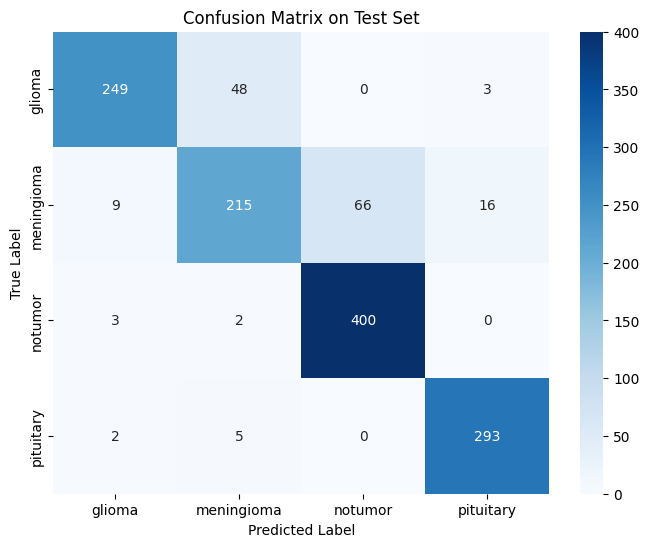

In [ ]:
show_classification_report_confusion_matrix(cnn_model, test_ds, class_names)

#### Save the model

In [ ]:
baseline_cnn.save("/content/drive/MyDrive/Brain_Tumor_Project/notebook/baseline_cnn_final.keras")

### B. CNN without augmentation using Flatten instead of GlobalAveragePooling

This experiment will use Flatten instead for GlobalAveragePooling as the final layer of the convolutional base.

#### Build and train the model

In [ ]:
cnn_no_aug, history_cnn_no_aug = run_experiment(
    experiment_name="cnn_no_aug",
    num_classes=num_classes,
    train_ds=train_ds,
    val_ds=val_ds,
    use_augmentation=False
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ no_augmentation (Sequential)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,508 (25.99 MB)

 Trainable params: 6,812,548 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

--------Training cnn_no_aug...---------
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 149ms/step - accuracy: 0.5939 - loss: 1.3965 - val_accuracy: 0.2137 - val_loss: 10.0687 - learning_rate: 1.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 79ms/step - accuracy: 0.7875 - loss: 0.5203 - val_accuracy: 0.3091 - val_loss: 3.8412 - learning_rate: 1.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 85ms/step - accuracy: 0.8319 - loss: 0.4298 - val_accuracy: 0.6357 - val_loss: 1.2478 - learning_rate: 1.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 89ms/step - accuracy: 0.8508 - loss: 0.3649 - val_accuracy: 0.8205 - val_loss: 0.5204 - learning_rate: 1.0000e-04
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - accuracy: 0.8659 - loss: 0.3273 - val_accuracy: 0.8643 - val_loss: 0.4144 - learning_rate: 1.0000e-04
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.8901 - loss: 0.2726 - val_accuracy: 0.9037 - val_loss: 0.3216 - learning_rate: 1.0000e-04
Epoch 7/30

In [ ]:
cnn_no_aug.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ no_augmentation (Sequential)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,438,606 (77.97 MB)

 Trainable params: 6,812,548 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 13,625,098 (51.98 MB)

#### Visualize metrics

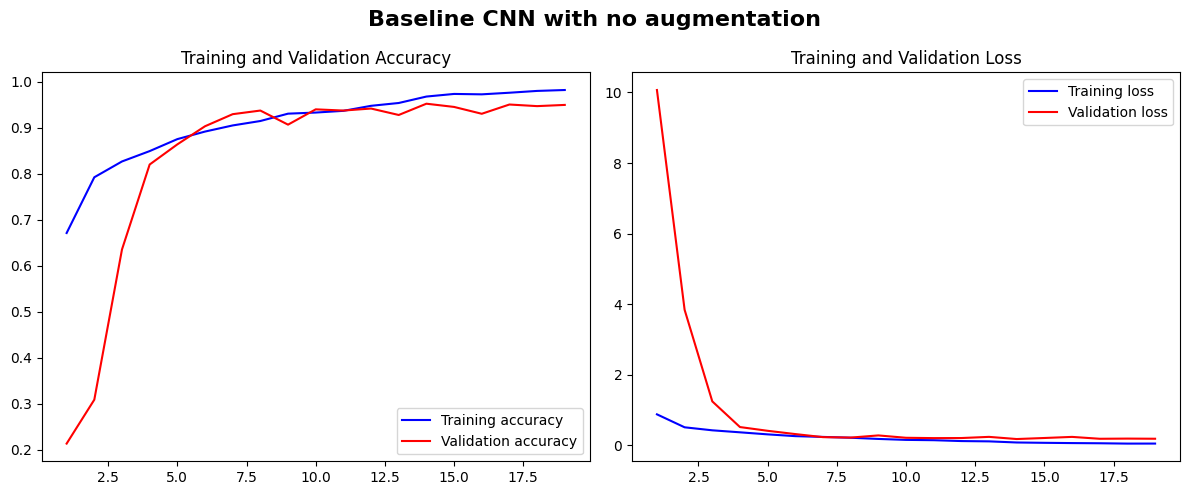

In [ ]:
plot_accuracy_and_loss(history_cnn_no_aug, "Baseline CNN with no augmentation")

In [ ]:
final_evaluation(cnn_no_aug)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9513 - loss: 0.2128
Validation Accuracy: 0.9527


In [ ]:
cnn_model = keras.models.load_model("/content/drive/MyDrive/Brain_Tumor_Project/notebook/baseline_cnn_final.keras")

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step
              precision    recall  f1-score   support

      glioma       0.95      0.83      0.88       300
  meningioma       0.80      0.70      0.75       306
     notumor       0.86      0.99      0.92       405
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.88      1311
weighted avg       0.88      0.88      0.88      1311



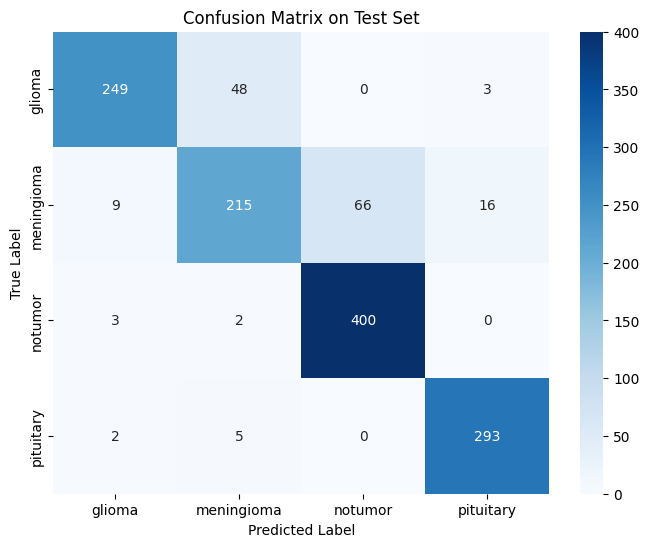

In [ ]:
show_classification_report_confusion_matrix(cnn_model, test_ds, class_names)

#### Conclusion

> We'll be using Flatten instead of GlobalAveragePooling

## II.Training a baseline CNN model with data augmentation

We'll be experimenting with different augmentation layers

### Building the pipeline

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),            # randomly flip horizontally
    layers.RandomRotation(0.05),                # rotate +-5%
    layers.RandomZoom(0.1),                     # random zoom
    # layers.RandomTranslation(0.1, 0.1),       # shift horizontally/vertically
    layers.RandomContrast(0.08),                # adjust contrast
    layers.RandomBrightness(factor=0.06),       # Slight brightness variation
], name="data_augmentation")


### Visualizing the effect of different augmentations on the same sample data

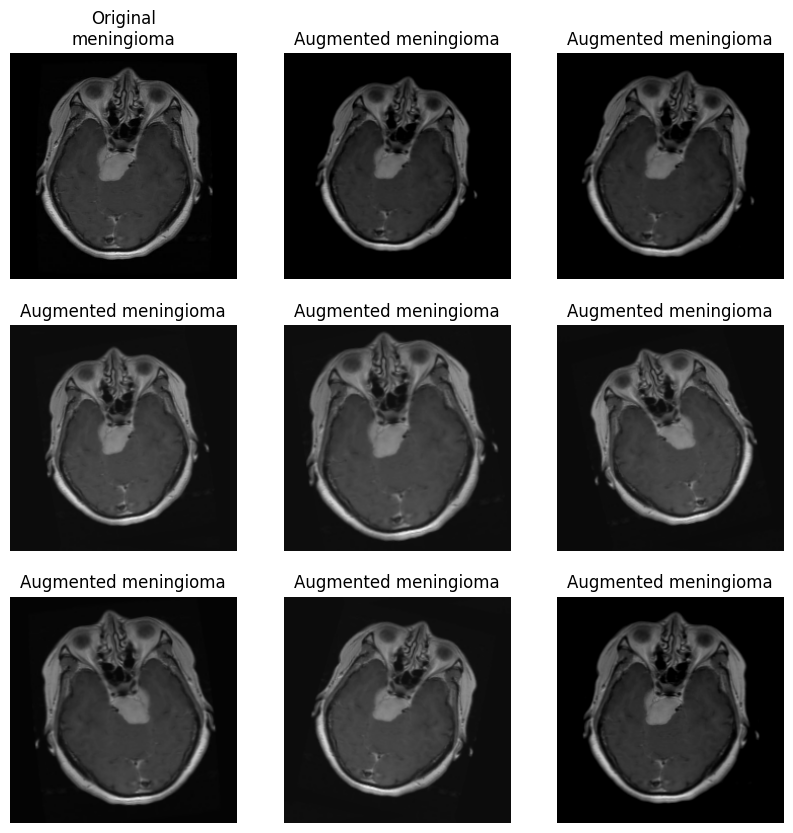

In [ ]:
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
    # Original image
    ax = plt.subplot(3, 3, 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    plt.title(f"Original\n{class_names[labels[0]]}")
    plt.axis("off")
    for i in range(8):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 2)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Augmented {class_names[labels[0]]}")
        plt.axis("off")


### Visualizing the effect of the augmentation on different samples

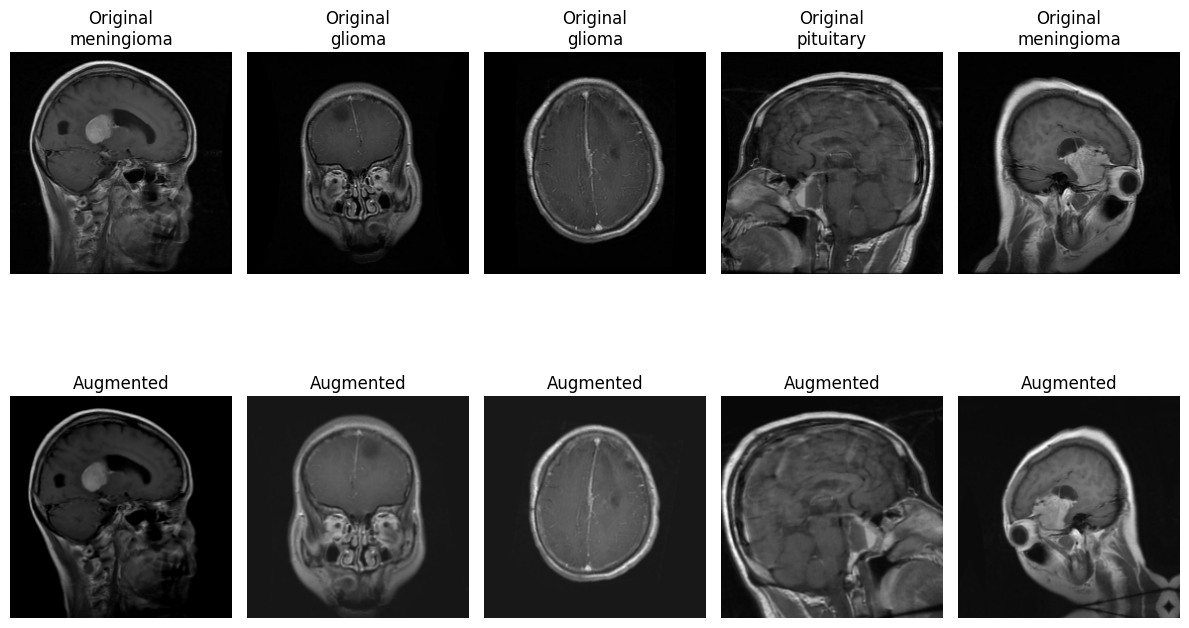

In [ ]:
# Take one batch of images and labels from the dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 8))

    # Show first 5 images from the batch
    for i in range(5):
        # Original image
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Original\n{class_names[labels[i]]}")
        plt.axis("off")

        # Augmented version
        augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
        ax = plt.subplot(2, 5, i + 6)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title("Augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


### A. CNN augmented with the stongest augmentation and with GlobalAveragePooling

#### Building the augmentation pipeline

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),            # randomly flip horizontally
    layers.RandomRotation(0.05),                # rotate +-5%
    layers.RandomZoom(0.1),                     # random zoom
    # layers.RandomTranslation(0.1, 0.1),       # shift horizontally/vertically
    layers.RandomContrast(0.08),                # adjust contrast
    layers.RandomBrightness(factor=0.06),       # Slight brightness variation
], name="data_augmentation")

#### Building the model

In [ ]:
num_classes = len(class_names)

baseline_cnn_augmented = models.Sequential([
    # Data Augmentation & Normalization
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Rescaling(1./255),

    # --- Convolutional Base ---
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    # --- Dense Head ---
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

baseline_cnn_augmented.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 423,748 (1.62 MB)

 Trainable params: 422,788 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
baseline_cnn_augmented.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


#### Training the model

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Brain_Tumor_Project/notebook/baseline_cnn_augmented_best.keras", save_best_only=True)
]

history_cnn_augmented = baseline_cnn_augmented.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.5614 - loss: 1.0434 - val_accuracy: 0.2172 - val_loss: 1.8866 - learning_rate: 1.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 156ms/step - accuracy: 0.6633 - loss: 0.8402 - val_accuracy: 0.2644 - val_loss: 2.5871 - learning_rate: 1.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.7270 - loss: 0.7165
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.7270 - loss: 0.7164 - val_accuracy: 0.2671 - val_loss: 3.2123 - learning_rate: 1.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/step - accuracy: 0.7510 - loss: 0.6767 - val_accuracy: 0.3634 - val_loss: 2.2840 - learning_rate: 3.0000e-05
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.7558 - loss: 0.6191 - val_accuracy: 0.5701 - val_loss: 1.1340 - learning_rate: 3.0000e-05
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 154ms/s

#### Visualizing the metrics

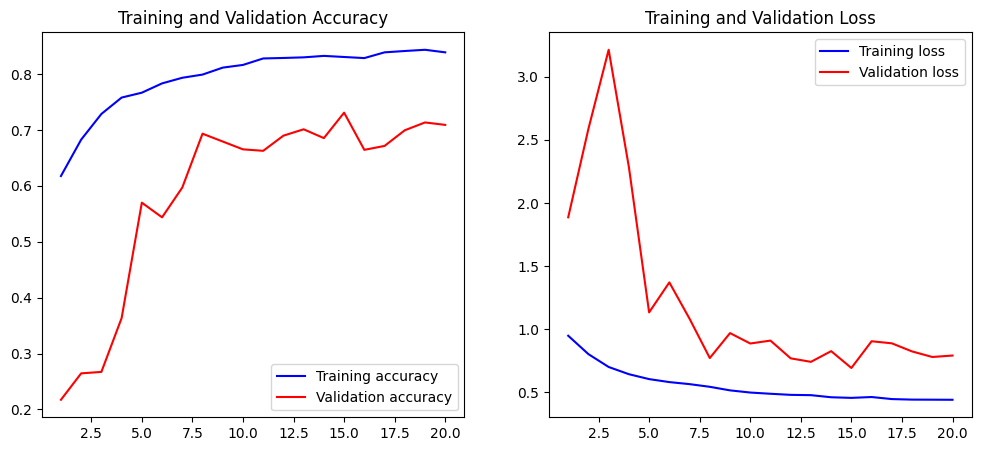

In [ ]:
import matplotlib.pyplot as plt

acc = history_cnn_augmented.history['accuracy']
val_acc = history_cnn_augmented.history['val_accuracy']
loss = history_cnn_augmented.history['loss']
val_loss = history_cnn_augmented.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
val_loss, val_acc = baseline_cnn_augmented.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7325 - loss: 0.6799
Validation Accuracy: 0.7312


#### Save the model

In [ ]:
baseline_cnn.save("/content/drive/MyDrive/Brain_Tumor_Project/notebook/baseline_cnn_augmented_final.keras")

> A huge dropdown in performance

### B. CNN augmented with safe augmentation and flatten

#### Building the augmentation pipeline

In [ ]:
data_augmentation_safe = keras.Sequential([
    layers.RandomFlip("horizontal"),            # Safe for brain scans
    layers.RandomRotation(0.02),                # Minimal rotation, e.g., +-0.7 degrees
    layers.RandomZoom(0.05),                    # Very slight zoom
], name="data_augmentation_safe")

#### Building the model

In [ ]:
cnn_safe_aug, history_cnn_safe_aug = run_experiment(
    experiment_name="cnn_safe_augmentation",
    num_classes=num_classes,
    train_ds=train_ds,
    val_ds=val_ds,
    use_augmentation=True,
    augmentation_layers=data_augmentation_safe
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation_safe          │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,508 (25.99 MB)

 Trainable params: 6,812,548 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

--------Training cnn_safe_augmentation...---------
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 162ms/step - accuracy: 0.6068 - loss: 1.2772 - val_accuracy: 0.2671 - val_loss: 5.5517 - learning_rate: 1.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.7516 - loss: 0.5840 - val_accuracy: 0.5280 - val_loss: 3.2136 - learning_rate: 1.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 176ms/step - accuracy: 0.7988 - loss: 0.5173 - val_accuracy: 0.7557 - val_loss: 0.9944 - learning_rate: 1.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 167ms/step - accuracy: 0.8172 - loss: 0.4487 - val_accuracy: 0.8354 - val_loss: 0.4981 - learning_rate: 1.0000e-04
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 170ms/step - accuracy: 0.8479 - loss: 0.3803 - val_accuracy: 0.8468 - val_loss: 0.3848 - learning_rate: 1.0000e-04
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 174ms/step - accuracy: 0.8471 - loss: 0.3689 - val_accuracy: 0.8932 - val_loss: 0.2590 - learning_rate: 1.0000

#### Visualizing metrics

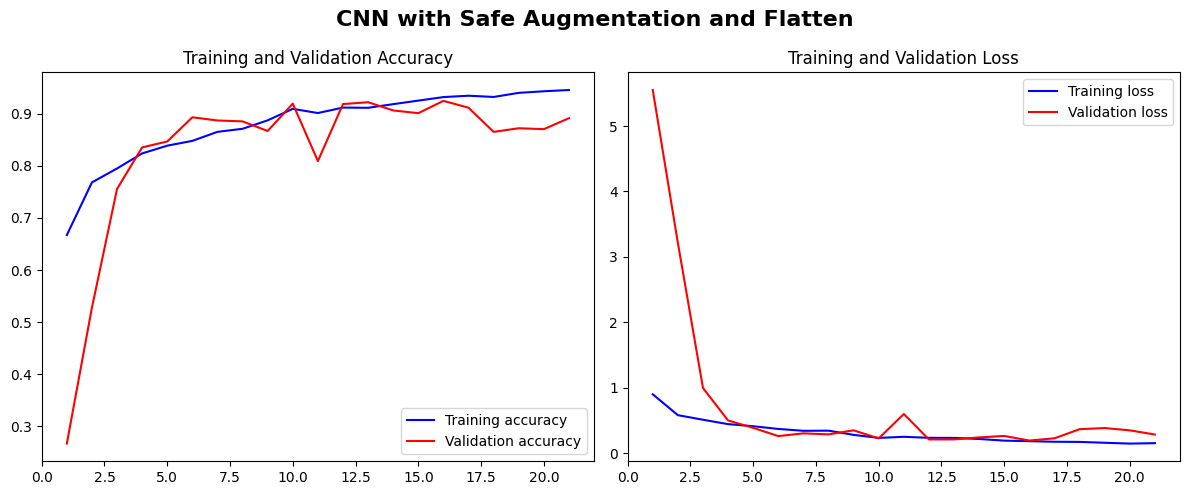

In [ ]:
plot_accuracy_and_loss(history_cnn_safe_aug, "CNN with Safe Augmentation and Flatten")

In [ ]:
final_evaluation(cnn_safe_aug)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9310 - loss: 0.1734
Validation Accuracy: 0.9247


In [ ]:
cnn_model = keras.models.load_model("/content/drive/MyDrive/Brain_Tumor_Project/notebook/baseline_cnn_augmented_final.keras")

In [ ]:
cnn_model.evaluate(val_ds)

36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 100ms/step - accuracy: 0.9223 - loss: 0.1966


[0.20831455290317535, 0.9246935248374939]

In [ ]:
cnn_model.evaluate(test_ds)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.8355 - loss: 0.4023


[0.30273184180259705, 0.8825324177742004]

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step
              precision    recall  f1-score   support

      glioma       0.95      0.83      0.88       300
  meningioma       0.80      0.70      0.75       306
     notumor       0.86      0.99      0.92       405
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.88      1311
   macro avg       0.89      0.87      0.88      1311
weighted avg       0.88      0.88      0.88      1311



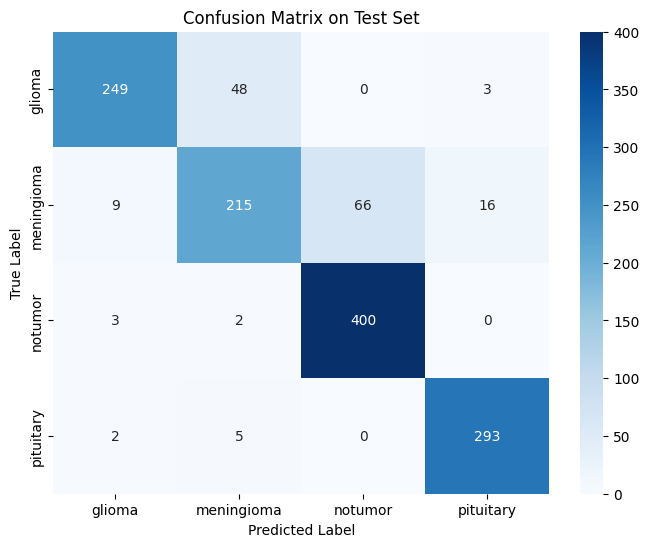

In [ ]:
show_classification_report_confusion_matrix(cnn_model, test_ds, class_names)

### C. cnn augmented with a slightly different augmentation and with flatten

#### Building the augmentation pipeline

In [ ]:
data_augmentation_safe_second = keras.Sequential([
    layers.RandomFlip("horizontal"),            # Safe for brain scans
    layers.RandomZoom(0.05),                    # Very slight zoom
    layers.RandomContrast(0.08),                # adjust contrast
    layers.RandomBrightness(factor=0.06),       # Slight brightness variation
], name="data_augmentation_safe_second")

#### Running the experiment

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation_safe_second   │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,813,508 (25.99 MB)

 Trainable params: 6,812,548 (25.99 MB)

 Non-trainable params: 960 (3.75 KB)

Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 177ms/step - accuracy: 0.6011 - loss: 1.4673 - val_accuracy: 0.2137 - val_loss: 9.5988 - learning_rate: 1.0000e-04
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 171ms/step - accuracy: 0.7356 - loss: 0.6219 - val_accuracy: 0.4177 - val_loss: 8.2805 - learning_rate: 1.0000e-04
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - accuracy: 0.7861 - loss: 0.5258 - val_accuracy: 0.4790 - val_loss: 3.0322 - learning_rate: 1.0000e-04
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 162ms/step - accuracy: 0.8072 - loss: 0.4631 - val_accuracy: 0.7049 - val_loss: 1.0100 - learning_rate: 1.0000e-04
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - accuracy: 0.8153 - loss: 0.4401 - val_accuracy: 0.8792 - val_loss: 0.3408 - learning_rate: 1.0000e-04
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 31s 171ms/step - accuracy: 0.8473 - loss: 0.3802 - val_accuracy: 0.9133 - val_loss: 0.2673 - learning_rate: 1.0000e-04
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 16

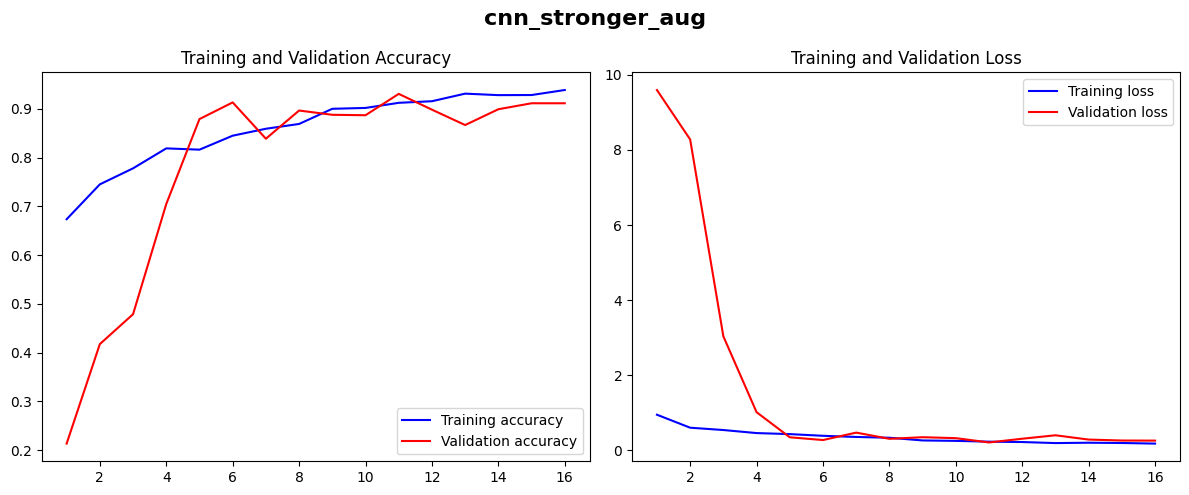

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9257 - loss: 0.2059
Validation Accuracy: 0.9308

 Experiment 'cnn_stronger_aug' completed!
Results saved in: /content/drive/MyDrive/Brain_Tumor_Project/experiments/cnn_stronger_aug


(<Sequential name=sequential, built=True>,
 <keras.src.callbacks.history.History at 0x7aeb008c1a60>)

In [ ]:
run_experiment(
    experiment_name="cnn_stronger_aug",
    num_classes=num_classes,
    train_ds=train_ds,
    val_ds=val_ds,
    use_augmentation=True,
    augmentation_layers=data_augmentation_safe_second
)

## III.Hyperparamter tuning of the baseline CNN

we will be using random search and Keras Tuner to tune parameters like:

- the number of filters in each convolutional layer
- the dropout rate for each dropout layer
- the number of dense units
- the optimizer
- the learning rate

### Define the model builder function

In [ ]:
# --- Define the model builder function ---
def build_model(hp):
    model = keras.Sequential([
        layers.Input(shape=(224, 224, 3)),
        data_augmentation,
        layers.Rescaling(1./255),

        # --- Tunable Convolutional Base ---
        layers.Conv2D(
            filters=hp.Choice('conv1_filters', [32, 64, 128]),
            kernel_size=3,
            activation='relu',
            padding='same'
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(
            filters=hp.Choice('conv2_filters', [64, 128, 256]),
            kernel_size=3,
            activation='relu',
            padding='same'
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(
            filters=hp.Choice('conv3_filters', [128, 256, 512]),
            kernel_size=3,
            activation='relu',
            padding='same'
        ),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Dropout(hp.Choice('conv_dropout', [0.2, 0.3, 0.4])),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling2D(),

        # --- Tunable Dense Head ---
        layers.Dense(
            units=hp.Choice('dense_units', [64, 128, 256]),
            activation='relu'
        ),
        layers.Dropout(hp.Choice('dense_dropout', [0.3, 0.5, 0.6])),

        layers.Dense(num_classes, activation='softmax')
    ])

    # --- Tunable Optimizer and Learning Rate ---
    hp_optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    if hp_optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    else:
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


### Define the RandomSearch Tuner

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # total random combinations to try
    executions_per_trial=1,  # each trial runs once; can set to >1 for averaging
    directory='/content/drive/MyDrive/Brain_Tumor_Project/notebook/tuning',
    project_name='baseline_cnn_randomsearch'
)


### Run the Search

In [ ]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs=15,                 # modest epoch count to test configurations
    callbacks=[stop_early]
)


Trial 20 Complete [00h 11m 56s]
val_accuracy: 0.8371278643608093

Best val_accuracy So Far: 0.8879159092903137
Total elapsed time: 03h 03m 37s


### Print the top-performing hyperparameter sets

In [ ]:
tuner.results_summary()

Results summary
Results in /content/drive/MyDrive/Brain_Tumor_Project/notebook/tuning/baseline_cnn_randomsearch
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 12 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 64
conv3_filters: 256
conv_dropout: 0.2
dense_units: 128
dense_dropout: 0.3
optimizer: rmsprop
learning_rate: 0.001
Score: 0.8879159092903137

Trial 04 summary
Hyperparameters:
conv1_filters: 32
conv2_filters: 64
conv3_filters: 512
conv_dropout: 0.3
dense_units: 256
dense_dropout: 0.6
optimizer: adam
learning_rate: 0.001
Score: 0.8852889537811279

Trial 00 summary
Hyperparameters:
conv1_filters: 64
conv2_filters: 64
conv3_filters: 128
conv_dropout: 0.3
dense_units: 256
dense_dropout: 0.6
optimizer: rmsprop
learning_rate: 0.001
Score: 0.8686515092849731

Trial 11 summary
Hyperparameters:
conv1_filters: 128
conv2_filters: 128
conv3_filters: 256
conv_dropout: 0.2
dense_units: 64
dense_dropout: 0.6
optimizer: adam
learning_rate: 0.001
Score: 0

### Retrieve and Train the Best Model

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Brain_Tumor_Project/notebook/cnn_augmented_best_model.keras", save_best_only=True)
]

In [ ]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param in best_hps.values.keys():
    print(f"{param}: {best_hps.get(param)}")

# Build model with best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train with full callbacks and longer training
history = best_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


Best Hyperparameters:
conv1_filters: 64
conv2_filters: 64
conv3_filters: 256
conv_dropout: 0.2
dense_units: 128
dense_dropout: 0.3
optimizer: rmsprop
learning_rate: 0.001
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - accuracy: 0.6167 - loss: 0.9450 - val_accuracy: 0.2636 - val_loss: 3.0846 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 261ms/step - accuracy: 0.7549 - loss: 0.6369 - val_accuracy: 0.2872 - val_loss: 4.1008 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - accuracy: 0.8089 - loss: 0.5132
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 257ms/step - accuracy: 0.8089 - loss: 0.5131 - val_accuracy: 0.3065 - val_loss: 3.9260 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 85s 267ms/step - accuracy: 0.8466 - loss: 0.4123 - val_accuracy: 0.6515 - val_loss: 1.3825 - learning_rate: 3.0000e-04
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 257ms/st

### View metrics

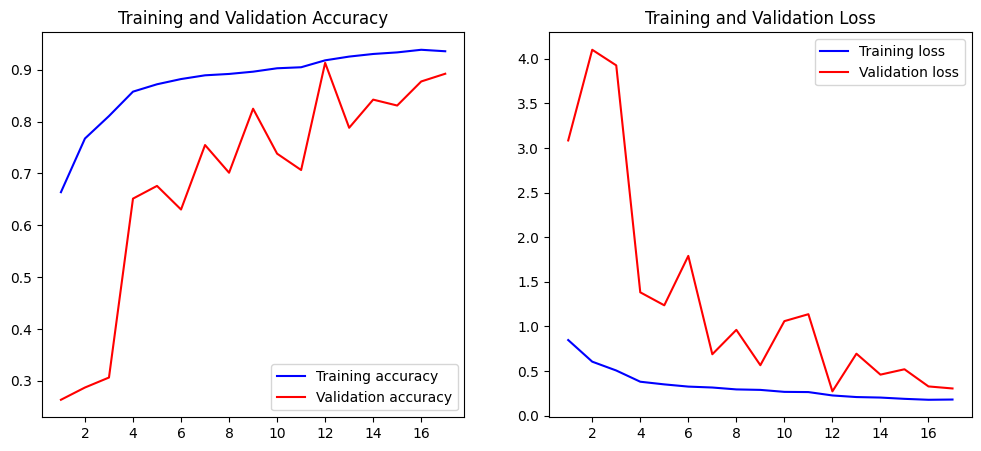

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


In [ ]:
val_loss, val_acc = best_model.evaluate(val_ds)
print(f"Validation Accuracy: {val_acc:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9115 - loss: 0.2632
Validation Accuracy: 0.9133


### Save the model

In [ ]:
best_model.save("/content/drive/MyDrive/Brain_Tumor_Project/notebook/cnn_best_model.keras")

### Using the best model from the first ever hyper param tuning with no augmentation

Best Hyperparameters:

conv1_filters: 64

conv2_filters: 64

conv3_filters: 256

conv_dropout: 0.2

dense_units: 128

dense_dropout: 0.3

optimizer: rmsprop

learning_rate: 0.001

In [ ]:
# Construct the model
model = models.Sequential([
    # Data Augmentation & Normalization
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),

    # --- Convolutional Base ---
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
experiment_name = "cnn_no_aug_best_hyperparam_old"
num_classes = len(class_names)
use_augmentation = False
learning_rate=0.001
epochs=30

# Create experiment folder
exp_path = create_experiment_folder(experiment_name)

# Save experiment config
save_experiment_config(exp_path, experiment_name, use_augmentation, learning_rate, epochs)

# Build the model
cnn_no_aug_best_hyperparam_old = models.Sequential([
    # Data Augmentation & Normalization
    layers.Input(shape=(224, 224, 3)),
    layers.Rescaling(1./255),

    # --- Convolutional Base ---
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

cnn_no_aug_best_hyperparam_old.summary()

cnn_no_aug_best_hyperparam_old.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


# Callbacks
checkpoint_path = os.path.join(exp_path, "best_model.keras")

callbacks = [
    # Stops training automatically when the model stops improving — to prevent overfitting and save time.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),

    # Avoids overshooting & helps model converge smoothly by dynamically changing the learning rate
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),

    # save the best performing version
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
]


# Train model
print(f"--------Training {experiment_name}...---------")
history_cnn_no_aug_best_hyperparam_old = cnn_no_aug_best_hyperparam_old.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)
print(f"--------Training {experiment_name} completed!---------")


# Save training curves
save_training_curves(exp_path, experiment_name, history_cnn_no_aug_best_hyperparam_old)

# Save history values
save_experiment_history(exp_path, history_cnn_no_aug_best_hyperparam_old)


# Save final model
save_final_model(exp_path, cnn_no_aug_best_hyperparam_old)
print(f"Results saved in: {exp_path}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,202,244 (27.47 MB)

 Trainable params: 7,200,964 (27.47 MB)

 Non-trainable params: 1,280 (5.00 KB)

--------Training cnn_no_aug_best_hyperparam_old...---------
Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 48s 214ms/step - accuracy: 0.5508 - loss: 4.5972 - val_accuracy: 0.2644 - val_loss: 2.0401 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 24s 128ms/step - accuracy: 0.6799 - loss: 0.8603 - val_accuracy: 0.3590 - val_loss: 1.6580 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 121ms/step - accuracy: 0.6996 - loss: 0.7670 - val_accuracy: 0.7277 - val_loss: 0.8266 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 125ms/step - accuracy: 0.7249 - loss: 0.6221 - val_accuracy: 0.7426 - val_loss: 0.6533 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 119ms/step - accuracy: 0.7494 - loss: 0.5985 - val_accuracy: 0.8135 - val_loss: 0.5245 - learning_rate: 0.0010
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 23s 119ms/step - accuracy: 0.7890 - loss: 0.5256 - val_accuracy: 0.8949 - val_loss: 0.3805 - learning_rate: 0.0010
Epoch 7/30

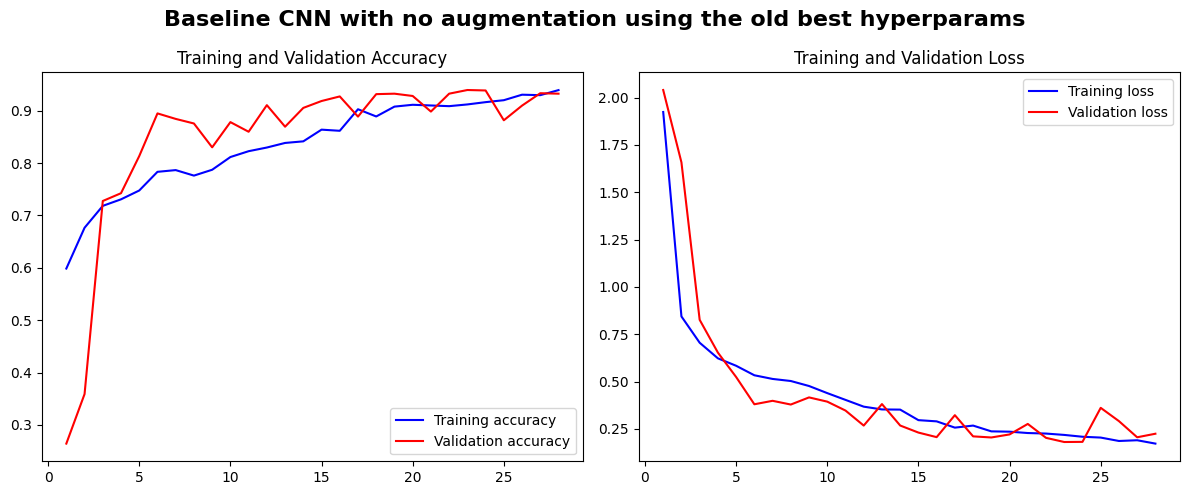

In [ ]:
plot_accuracy_and_loss(history_cnn_no_aug_best_hyperparam_old, "Baseline CNN with no augmentation using the old best hyperparams")

In [ ]:
final_evaluation(cnn_no_aug_best_hyperparam_old)

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9443 - loss: 0.1726
Validation Accuracy: 0.9396


# Pahse 2: Using transfer learning on a ResNet50 model

##Load Pretrained ResNet50 Base

In [ ]:
# Input shape
input_shape = (224, 224, 3)

# Load ResNet50 base without top layers
base_model = ResNet50(
    weights='imagenet',   # pretrained on ImageNet
    include_top=False,    # exclude default dense classifier
    input_shape=input_shape
)

# Freeze all base layers initially
base_model.trainable = False


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

## Build the Custom Model

### A. Without using augmentation

#### Setup

In [ ]:
experiment_name = "resnet50_no_aug_frozen"
num_classes = len(class_names)
use_augmentation = False
learning_rate=1e-3
epochs = 30

# Create experiment folder
exp_path = create_experiment_folder(experiment_name)

# Save experiment config
save_experiment_config(exp_path, experiment_name, use_augmentation, learning_rate, epochs)

#### Add a custom dense head

In [ ]:
inputs = keras.Input(shape=input_shape)

# No augmentation


# Preprocess for ResNet50
x = preprocess_input(inputs)  # rescales and normalizes images as ResNet expects

# Pass through the ResNet50 base
x = base_model(x, training=False)

# Global average pooling to flatten feature maps
x = layers.GlobalAveragePooling2D()(x)

# Dense head
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
resnet_model = keras.Model(inputs, outputs)


In [ ]:
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Train the frozen model

In [ ]:
# Callbacks
checkpoint_path = os.path.join(exp_path, "best_model.keras")

callbacks = [
    # Stops training automatically when the model stops improving — to prevent overfitting and save time.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),

    # Avoids overshooting & helps model converge smoothly by dynamically changing the learning rate
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),

    # save the best performing version
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
]

In [ ]:
history_frozen = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 53s 219ms/step - accuracy: 0.7234 - loss: 0.7241 - val_accuracy: 0.8958 - val_loss: 0.2662 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 57s 107ms/step - accuracy: 0.8758 - loss: 0.3130 - val_accuracy: 0.9151 - val_loss: 0.2234 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 116ms/step - accuracy: 0.9076 - loss: 0.2473 - val_accuracy: 0.9212 - val_loss: 0.1994 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 101ms/step - accuracy: 0.9140 - loss: 0.2202 - val_accuracy: 0.9256 - val_loss: 0.2060 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.9315 - loss: 0.1861 - val_accuracy: 0.9343 - val_loss: 0.1724 - learning_rate: 0.0010
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 123ms/step - accuracy: 0.9419 - loss: 0.1568 - val_accuracy: 0.9396 - val_loss: 0.1683 - learning_rate: 0.0010
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9

In [ ]:
# Save training curves
save_training_curves(exp_path, experiment_name, history_frozen)

# Save history values
save_experiment_history(exp_path, history_frozen)


# Save final model
save_final_model(exp_path, resnet_model)
print(f"Results saved in: {exp_path}")


Results saved in: /content/drive/MyDrive/Brain_Tumor_Project/experiments/resnet50_no_aug_frozen


#### Visualize metrics

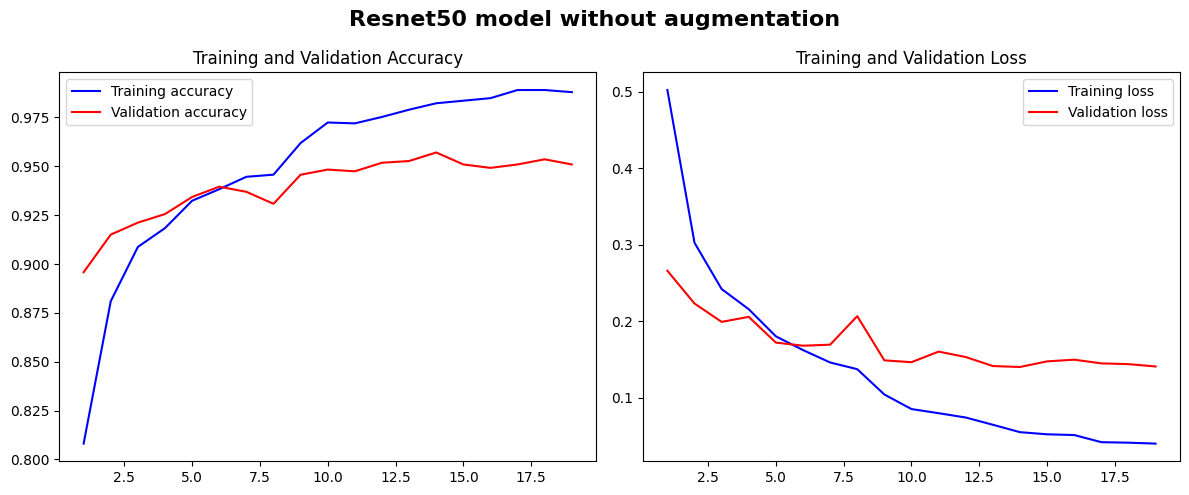

In [ ]:
plot_accuracy_and_loss(history_frozen, "Resnet50 model without augmentation")

In [ ]:
final_evaluation(resnet_model)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9623 - loss: 0.1218
Validation Accuracy: 0.9571


#### Fine-Tune the Last 50 Layers of ResNet50

##### Create functions to run finetuning experiment

In [ ]:
def save_fine_tuning_experiment_config(exp_path, experiment_name, use_augmentation, fine_tune_lr, fine_tune_epochs, n_layers_to_freeze):
    config = {
        'experiment_name': experiment_name,
        'use_augmentation': use_augmentation,
        'fine_tune_lr': fine_tune_lr,
        'fine_tune_epochs': fine_tune_epochs,
        'n_layers_to_freeze': n_layers_to_freeze
    }
    with open(os.path.join(exp_path, "config.json"), "w") as f:
        json.dump(config, f, indent=4)

In [ ]:
def run_finetuning_experiment(
    experiment_name,
    base_frozen_model_path,
    train_ds,
    val_ds,
    num_classes,
    initial_epoch,
    n_layers_to_freeze,
    fine_tune_lr=1e-5,
    fine_tune_epochs=40,
    use_augmentation=False,
):
    """
    Loads a model previously trained with a frozen base, unfreezes a specified
    number of layers, and trains the model with a low learning rate.

    Args:
        experiment_name (str): Unique name for the experiment run.
        base_frozen_model_path (str): Path to the model saved after initial frozen-base training.
        train_ds (tf.data.Dataset): Training dataset.
        val_ds (tf.data.Dataset): Validation dataset.
        num_classes (int): Number of output classes (for configuration tracking).
        initial_epoch (int): The epoch number where the frozen-base training ended.
        n_layers_to_freeze (int): Number of layers of the base model to freeze.
        fine_tune_lr (float): Learning rate for the fine-tuning phase (e.g., 1e-5).
        fine_tune_epochs (int): Total epochs to run the fine-tuning phase for.
        use_augmentation (bool, optional): Whether augmentation was used (for config).
    """

    print(f"\n--- Starting Experiment: {experiment_name} ---")

    # 1. Setup paths and configuration saving
    exp_path = create_experiment_folder(experiment_name)
    save_fine_tuning_experiment_config(exp_path, experiment_name, use_augmentation, fine_tune_lr, fine_tune_epochs, n_layers_to_freeze)

    # 2. Load the model from the initial training phase
    try:
        resnet_model = keras.models.load_model(base_frozen_model_path)
    except Exception as e:
        print(f"ERROR: Could not load base model from {base_frozen_model_path}. Ensure the path is correct and the model is saved in .keras format.")
        print(f"Details: {e}")
        return

    # 3. Identify and unfreeze layers

    # Find the ResNet50 layer within the loaded model (assuming it's the layer named 'resnet50')
    try:
        base_model = resnet_model.get_layer('resnet50')
    except ValueError:
        print("ERROR: Could not find a layer named 'resnet50'. Please inspect your model summary to find the correct base model layer name.")
        return

    # Ensure the base model's trainable state is correctly set to True first
    base_model.trainable = True

    num_total_layers = len(base_model.layers)

    print(f"Total layers in base model: {num_total_layers}")
    print(f"Freezing first {n_layers_to_freeze})...")

    # Freeze the first `num_layers_to_freeze` layers
    for layer in base_model.layers[:n_layers_to_freeze]:
        layer.trainable = False

    # 4. Compile with a low learning rate for fine-tuning
    resnet_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=fine_tune_lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    print(f"Model recompiled with LR: {fine_tune_lr}")

    # 5. Define Callbacks
    checkpoint_path = os.path.join(exp_path, "best_model.keras")

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
    ]

    # 6. Fit the model (Fine-tuning phase)
    print("Starting fine-tuning...")
    history_finetune = resnet_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=fine_tune_epochs,
        initial_epoch=initial_epoch, # Starts training from the epoch where the frozen training ended
        callbacks=callbacks,
        verbose=1
    )

    # 7. Save results and final model
    save_training_curves(exp_path, experiment_name, history_finetune)
    save_experiment_history(exp_path, history_finetune)
    save_final_model(exp_path, resnet_model)

    print(f"--- Experiment {experiment_name} COMPLETE. Results saved in: {exp_path} ---")
    return resnet_model, history_finetune


##### Load the Best Model and Unfreeze Layers

In [ ]:
experiment_name = "resnet50_no_aug_unfreezing_last_50"
num_classes = len(class_names)
use_augmentation = False
fine_tune_lr = 1e-5
fine_tune_epochs = 40

# Create experiment folder
exp_path = create_experiment_folder(experiment_name)

# Save experiment config
save_experiment_config(exp_path, experiment_name, use_augmentation, fine_tune_lr, fine_tune_epochs)

In [ ]:
# Unfreeze the last 50 layers of the base model
base_model.trainable = True
for layer in base_model.layers[:-50]:  # freeze all but last 50 layers
    layer.trainable = False

# Compile with a lower learning rate for fine-tuning
fine_tune_lr = 1e-5
resnet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Callbacks
checkpoint_path = os.path.join(exp_path, "best_model.keras")

callbacks = [
    # Stops training automatically when the model stops improving — to prevent overfitting and save time.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),

    # Avoids overshooting & helps model converge smoothly by dynamically changing the learning rate
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1), # Reduce the minimum learning rate

    # save the best performing version
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
]

##### Train the model with the unfrozen layers

In [ ]:
# Fine-tune
history_finetune = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    initial_epoch= 19 #or history_frozen.epoch[-1], # history_frozen needs to be available
    callbacks=callbacks
)

Epoch 19/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 81s 292ms/step - accuracy: 0.8729 - loss: 0.4593 - val_accuracy: 0.9501 - val_loss: 0.1655 - learning_rate: 1.0000e-05
Epoch 20/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 30s 168ms/step - accuracy: 0.9706 - loss: 0.0805 - val_accuracy: 0.9571 - val_loss: 0.1482 - learning_rate: 1.0000e-05
Epoch 21/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 160ms/step - accuracy: 0.9849 - loss: 0.0474 - val_accuracy: 0.9571 - val_loss: 0.1491 - learning_rate: 1.0000e-05
Epoch 22/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 165ms/step - accuracy: 0.9912 - loss: 0.0284 - val_accuracy: 0.9580 - val_loss: 0.1445 - learning_rate: 1.0000e-05
Epoch 23/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 168ms/step - accuracy: 0.9946 - loss: 0.0207 - val_accuracy: 0.9606 - val_loss: 0.1416 - learning_rate: 1.0000e-05
Epoch 24/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 156ms/step - accuracy: 0.9935 - loss: 0.0173 - val_accuracy: 0.9615 - val_loss: 0.1418 - learning_rate: 1.0000e-05
Epoch 25/40
143/143 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Save training curves
save_training_curves(exp_path, experiment_name, history_finetune)

# Save history values
save_experiment_history(exp_path, history_finetune)


# Save final model
save_final_model(exp_path, resnet_model)
print(f"Results saved in: {exp_path}")


Results saved in: /content/drive/MyDrive/Brain_Tumor_Project/experiments/resnet50_no_aug_unfreezing_last_50


##### Visualize metrics

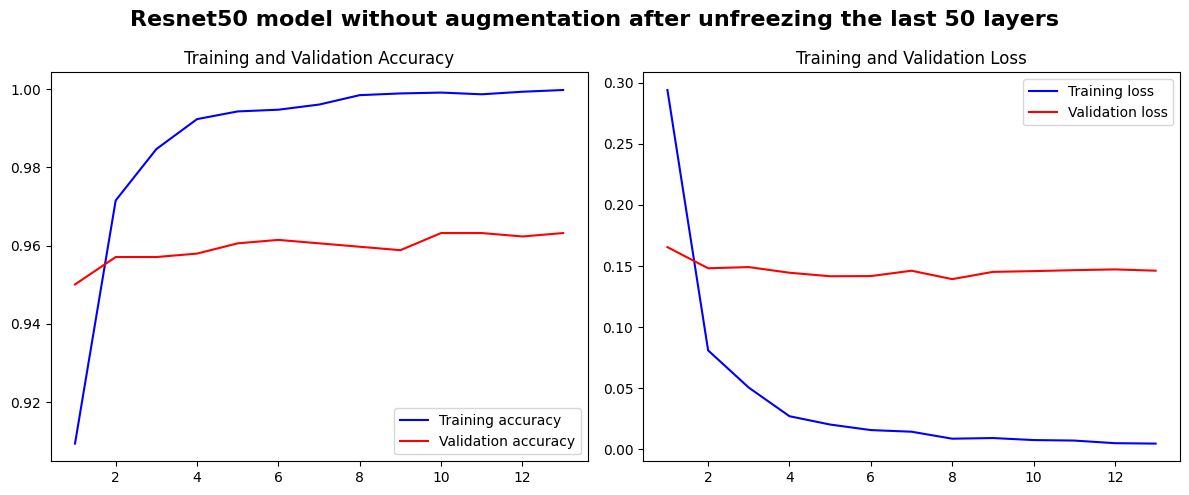

In [ ]:
plot_accuracy_and_loss(history_finetune, "Resnet50 model without augmentation after unfreezing the last 50 layers")

In [ ]:
final_evaluation(resnet_model)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.9674 - loss: 0.1182
Validation Accuracy: 0.9597


##### Save model

In [ ]:
# Load the model with the best weights
best_model = keras.models.load_model("/content/drive/MyDrive/Brain_Tumor_Project/experiments/resnet50_no_aug_unfreezing_last_50/final_model.keras")

##### Eavaluate on the test data

In [ ]:
best_model.evaluate(test_ds)

41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.9394 - loss: 0.2472


[0.15754123032093048, 0.9549961686134338]

41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.92      0.94       300
  meningioma       0.90      0.91      0.90       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



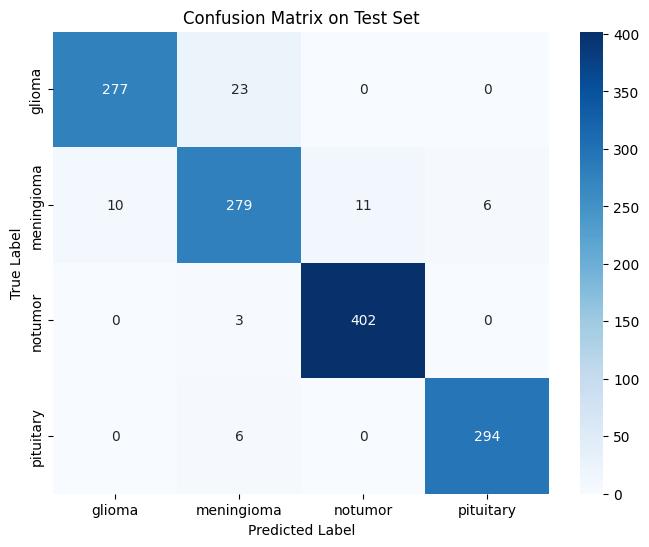

In [ ]:
show_classification_report_confusion_matrix(best_model, test_ds, class_names)

#### Fine-Tune the Last Few Layers of ResNet50: only freezing the first 39 (Corresponding to the first block)

In [ ]:
# Define experiment parameters
EXP_PARAMS = {
    'experiment_name': "finetune_resnet50_freeze_first_39",
    'base_frozen_model_path': "/content/drive/MyDrive/Brain_Tumor_Project/experiments/resnet50_no_aug_frozen/final_model.keras",
    'train_ds': train_ds,
    'val_ds': val_ds,
    'num_classes': num_classes,
    'initial_epoch': 19,
    'n_layers_to_freeze': 39,           # Unfreeze the last layers (approx Stage 3, 4 & 5)
    'fine_tune_lr': 1e-5,
    'fine_tune_epochs': 40,
    'use_augmentation': False,
}

In [ ]:
resnet50_freeze_first_39, history_resnet50_freeze_first_39 = run_finetuning_experiment(**EXP_PARAMS)


--- Starting Experiment: finetune_resnet50_freeze_first_39 ---
Total layers in base model: 175
Freezing first 39)...
Model recompiled with LR: 1e-05
Starting fine-tuning...
Epoch 20/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 130s 496ms/step - accuracy: 0.8165 - loss: 0.7271 - val_accuracy: 0.8643 - val_loss: 0.3858 - learning_rate: 1.0000e-05
Epoch 21/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 51s 310ms/step - accuracy: 0.9506 - loss: 0.1254 - val_accuracy: 0.9317 - val_loss: 0.1912 - learning_rate: 1.0000e-05
Epoch 22/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 74s 265ms/step - accuracy: 0.9824 - loss: 0.0547 - val_accuracy: 0.9562 - val_loss: 0.1302 - learning_rate: 1.0000e-05
Epoch 23/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 268ms/step - accuracy: 0.9899 - loss: 0.0340 - val_accuracy: 0.9615 - val_loss: 0.1177 - learning_rate: 1.0000e-05
Epoch 24/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 251ms/step - accuracy: 0.9959 - loss: 0.0167 - val_accuracy: 0.9641 - val_loss: 0.1239 - learning_rate: 1.0000e-05
Epoch 25/40
143/143 ━━━━━

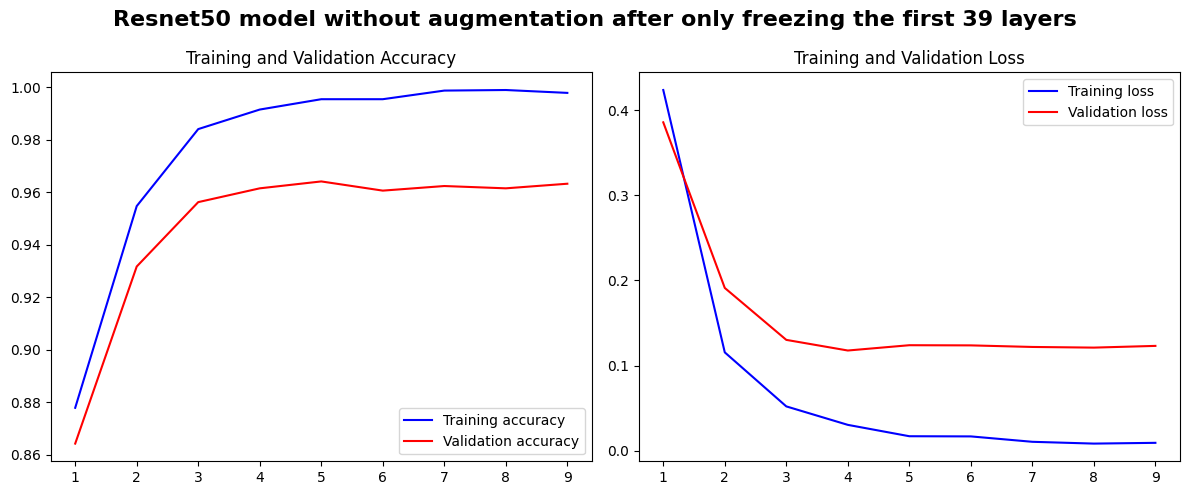

In [ ]:
plot_accuracy_and_loss(history_resnet50_freeze_first_39, "Resnet50 model without augmentation after only freezing the first 39 layers")

In [ ]:
final_evaluation(resnet50_freeze_first_39)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - accuracy: 0.9594 - loss: 0.1027
Validation Accuracy: 0.9615


In [ ]:
best_model_final = keras.models.load_model('/content/drive/MyDrive/Brain_Tumor_Project/experiments/finetune_resnet50_freeze_first_39/final_model.keras')

In [ ]:
best_model_final.evaluate(test_ds)

41/41 ━━━━━━━━━━━━━━━━━━━━ 17s 191ms/step - accuracy: 0.9387 - loss: 0.2250


[0.13993383944034576, 0.9588100910186768]

41/41 ━━━━━━━━━━━━━━━━━━━━ 13s 169ms/step
              precision    recall  f1-score   support

      glioma       0.97      0.91      0.94       300
  meningioma       0.90      0.93      0.91       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



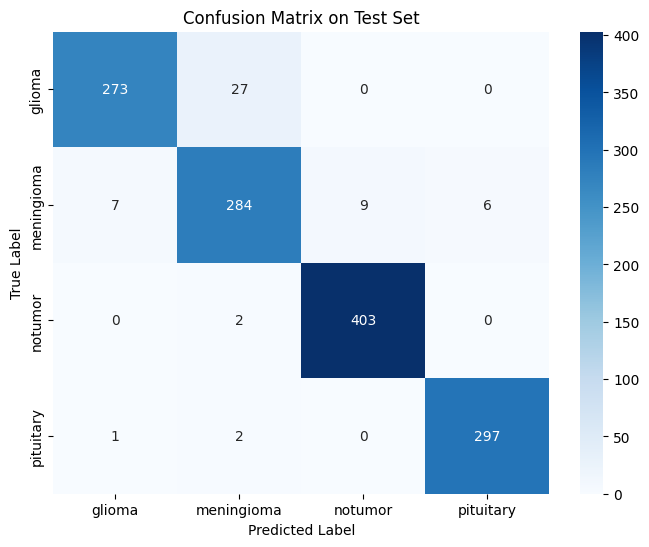

In [ ]:
show_classification_report_confusion_matrix(best_model_final, test_ds, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


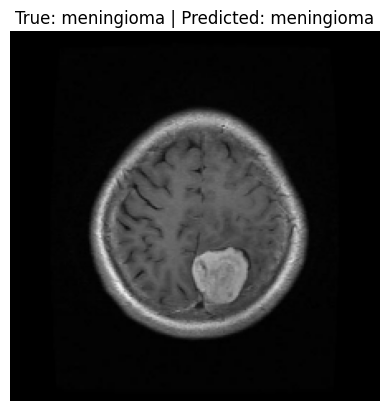

True label: meningioma
Predicted label: meningioma


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Convert the dataset to a list of (image, label)
test_images = []
test_labels = []

for img, label in test_ds.unbatch():
    test_images.append(img.numpy())
    test_labels.append(label.numpy())

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# -------------------------
# 1. Pick a random index
# -------------------------
idx = np.random.randint(0, len(test_images))

sample_img = test_images[idx]
true_label = test_labels[idx]

# -------------------------
# 2. Prepare image for model
# -------------------------
input_img = np.expand_dims(sample_img, axis=0)  # (1, H, W, C)

# -------------------------
# 3. Predict
# -------------------------
pred = best_model_final.predict(input_img)
pred_label = np.argmax(pred, axis=1)[0]

# -------------------------
# 4. Display results
# -------------------------
plt.imshow(sample_img.astype("uint8"))
plt.axis("off")
plt.title(f"True: {class_names[true_label]} | Predicted: {class_names[pred_label]}")
plt.show()

print("True label:", class_names[true_label])
print("Predicted label:", class_names[pred_label])


#### Fine-Tune the Last Few Layers of ResNet50 only freezing the first 85 (Corresponding to the first 2 blocks)

In [ ]:
# Define experiment parameters
EXP_PARAMS_85 = {
    'experiment_name': "finetune_resnet50_no_aug_freeze_first_85",
    'base_frozen_model_path': "/content/drive/MyDrive/Brain_Tumor_Project/experiments/resnet50_no_aug_frozen/final_model.keras",
    'train_ds': train_ds,
    'val_ds': val_ds,
    'num_classes': num_classes,
    'initial_epoch': 19,
    'n_layers_to_freeze': 85,           # Unfreeze the last layers (approx Stage 3, 4 & 5)
    'fine_tune_lr': 1e-5,
    'fine_tune_epochs': 40,
    'use_augmentation': False,
}

In [ ]:
resnet50_freeze_first_85, history_resnet50_freeze_first_85 = run_finetuning_experiment(**EXP_PARAMS_85)


--- Starting Experiment: finetune_resnet50_no_aug_freeze_first_85 ---
Total layers in base model: 175
Freezing first 85)...
Model recompiled with LR: 1e-05
Starting fine-tuning...
Epoch 20/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 89s 363ms/step - accuracy: 0.8234 - loss: 0.6552 - val_accuracy: 0.9510 - val_loss: 0.1580 - learning_rate: 1.0000e-05
Epoch 21/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 233ms/step - accuracy: 0.9623 - loss: 0.0994 - val_accuracy: 0.9597 - val_loss: 0.1268 - learning_rate: 1.0000e-05
Epoch 22/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 200ms/step - accuracy: 0.9847 - loss: 0.0450 - val_accuracy: 0.9597 - val_loss: 0.1313 - learning_rate: 1.0000e-05
Epoch 23/40
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - accuracy: 0.9914 - loss: 0.0323
Epoch 23: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
143/143 ━━━━━━━━━━━━━━━━━━━━ 33s 196ms/step - accuracy: 0.9914 - loss: 0.0323 - val_accuracy: 0.9632 - val_loss: 0.1304 - learning_rate: 1.0000e-05
Epoch 24/40
143/143 ━━━━━

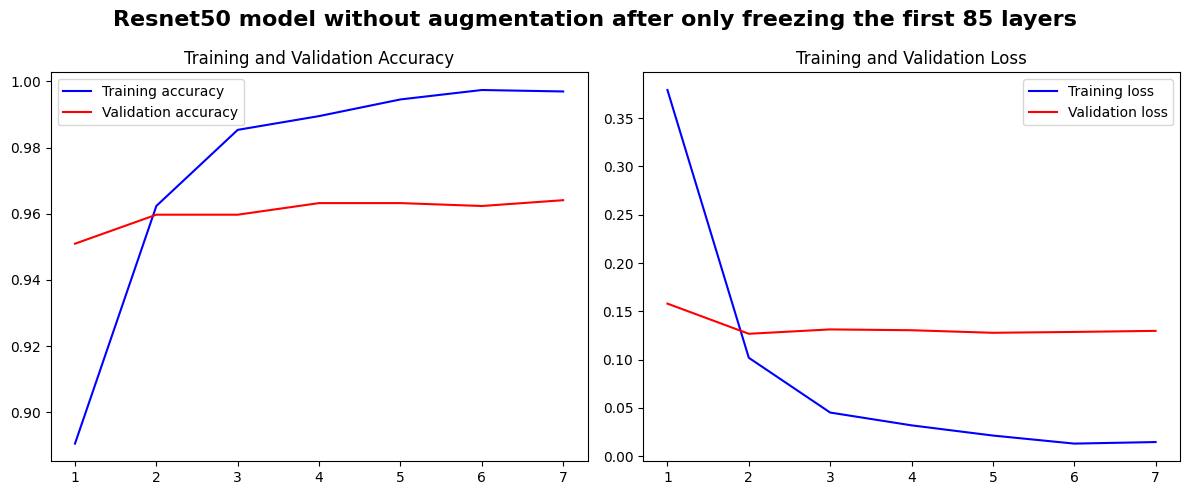

In [ ]:
plot_accuracy_and_loss(history_resnet50_freeze_first_85, "Resnet50 model without augmentation after only freezing the first 85 layers")

In [ ]:
final_evaluation(resnet50_freeze_first_85)

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9650 - loss: 0.1065
Validation Accuracy: 0.9597


In [ ]:
best_model_final = keras.models.load_model('/content/drive/MyDrive/Brain_Tumor_Project/experiments/resnet50_no_aug_frozen/final_model.keras')

In [ ]:
best_model_final.evaluate(test_ds)

41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9214 - loss: 0.2536


[0.17810282111167908, 0.9435545206069946]

41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 171ms/step
              precision    recall  f1-score   support

      glioma       0.95      0.88      0.92       300
  meningioma       0.87      0.91      0.89       306
     notumor       0.98      0.99      0.98       405
   pituitary       0.97      0.98      0.98       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



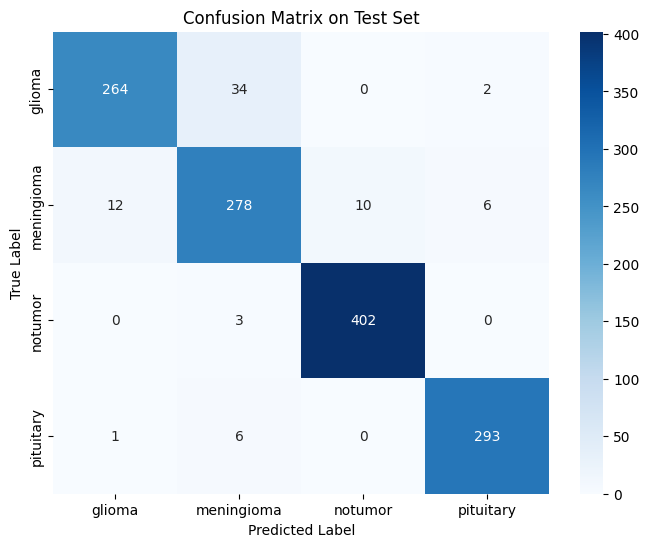

In [ ]:
show_classification_report_confusion_matrix(best_model_final, test_ds, class_names)

## Phase3: Using transfer learning on the VGG16 model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input


Conclusion from Experiments

1. Unfreezing is Key: The best result came from unfreezing most of the ResNet50 base (freezing only the first 39 layers), indicating that the features learned on ImageNet need significant adaptation for MRI scans.

2. Global Average Pooling is Superior: GlobalAveragePooling ($0.9615$) consistently outperformed Flatten ($0.9475$ best) for feature map compression.

3. Augmentation is Detrimental (for now): Both strong and moderate augmentation reduced accuracy. This is common in medical imaging because simple operations like strong contrast shifts or zooms can destroy subtle, vital diagnostic features.

## Load Pretrained VGG16 Base

In [ ]:
# Input shape same as your dataset
input_shape = (224, 224, 3)

# Load VGG16 base without top layers
base_model_vgg = VGG16(
    weights='imagenet',   # pretrained on ImageNet
    include_top=False,    # exclude default classifier
    input_shape=input_shape
)

# Freeze all base layers initially
base_model_vgg.trainable = False


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
base_model_vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## Build the Custom Model

In [ ]:
inputs = keras.Input(shape=input_shape)

# Preprocess for VGG16
x = preprocess_input(inputs)  # scales pixel values as VGG16 expects

# Pass through the VGG16 base
x = base_model_vgg(x, training=False)

# Global average pooling to flatten features
x = layers.Flatten()(x)

# Dense head
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create the model
vgg_model = keras.Model(inputs, outputs)


In [ ]:
vgg_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 3,211,908 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Compile the Model

In [ ]:
vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


## Train the Top Layers (Frozen Base)

In [ ]:
callbacks = [
    # Stops training automatically when the model stops improving — to prevent overfitting and save time.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    # Avoids overshooting & helps model converge smoothly by dynamically changing the learning rate
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    # save the best performing version
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Brain_Tumor_Project/experiments/vgg_model.keras", save_best_only=True)
]

In [ ]:
history_frozen_vgg = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)


Epoch 1/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 77s 370ms/step - accuracy: 0.6976 - loss: 7.8330 - val_accuracy: 0.8275 - val_loss: 0.4569 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 212ms/step - accuracy: 0.8268 - loss: 0.5016 - val_accuracy: 0.8415 - val_loss: 0.3877 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 208ms/step - accuracy: 0.8392 - loss: 0.4232 - val_accuracy: 0.8844 - val_loss: 0.3073 - learning_rate: 0.0010
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 206ms/step - accuracy: 0.8820 - loss: 0.3447 - val_accuracy: 0.9221 - val_loss: 0.2588 - learning_rate: 0.0010
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - accuracy: 0.9114 - loss: 0.2748 - val_accuracy: 0.9282 - val_loss: 0.2183 - learning_rate: 0.0010
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 203ms/step - accuracy: 0.9184 - loss: 0.2219 - val_accuracy: 0.9212 - val_loss: 0.2217 - learning_rate: 0.0010
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.92

## Evaluate the Model

In [ ]:
val_loss, val_acc = vgg_model.evaluate(val_ds)
print(f"Validation Accuracy after fine-tuning VGG16: {val_acc:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.9525 - loss: 0.1554
Validation Accuracy after fine-tuning VGG16: 0.9431


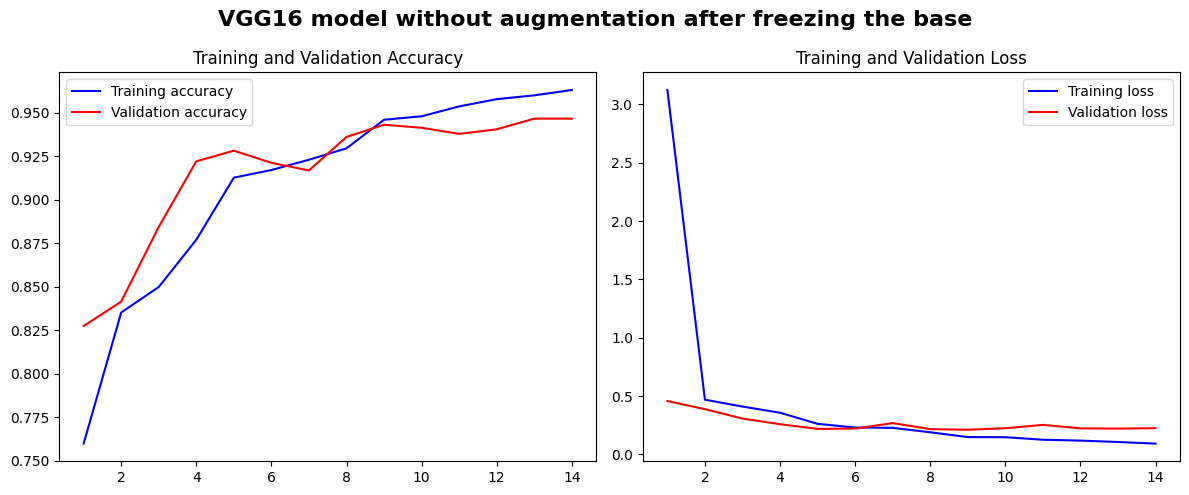

In [ ]:
plot_accuracy_and_loss(history_frozen_vgg, "VGG16 model without augmentation after freezing the base")

## Fine-Tune the Last Few Convolutional Layers

In [ ]:
# Unfreeze the last N layers of the base model
base_model_vgg.trainable = True
for layer in base_model_vgg.layers[:-5]:  # freeze all but last 5 convolutional layers
    layer.trainable = False

# Compile with a smaller learning rate for fine-tuning
vgg_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
vgg_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 224, 224)  │          0 │ input_layer_2[0]… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 224, 224,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 224, 224,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │        516 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 10,291,332 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
callbacks = [
    # Stops training automatically when the model stops improving — to prevent overfitting and save time.
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    # Avoids overshooting & helps model converge smoothly by dynamically changing the learning rate
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    # save the best performing version
    tf.keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Brain_Tumor_Project/experiments/vgg_model_unfrozen.keras", save_best_only=True)
]

In [ ]:
# Fine-tune
history_finetune_vgg = vgg_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 50s 278ms/step - accuracy: 0.9465 - loss: 0.1368 - val_accuracy: 0.9440 - val_loss: 0.1903 - learning_rate: 1.0000e-05
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 227ms/step - accuracy: 0.9586 - loss: 0.1048 - val_accuracy: 0.9378 - val_loss: 0.2343 - learning_rate: 1.0000e-05
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.9598 - loss: 0.1059
Epoch 3: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 232ms/step - accuracy: 0.9598 - loss: 0.1059 - val_accuracy: 0.9501 - val_loss: 0.2223 - learning_rate: 1.0000e-05
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 228ms/step - accuracy: 0.9604 - loss: 0.0963 - val_accuracy: 0.9536 - val_loss: 0.2075 - learning_rate: 5.0000e-06
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9729 - loss: 0.0791
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 230ms/step - a

In [ ]:
val_loss, val_acc = vgg_model.evaluate(val_ds)
print(f"Validation Accuracy after fine-tuning VGG16: {val_acc:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.9462 - loss: 0.1517
Validation Accuracy after fine-tuning VGG16: 0.9440


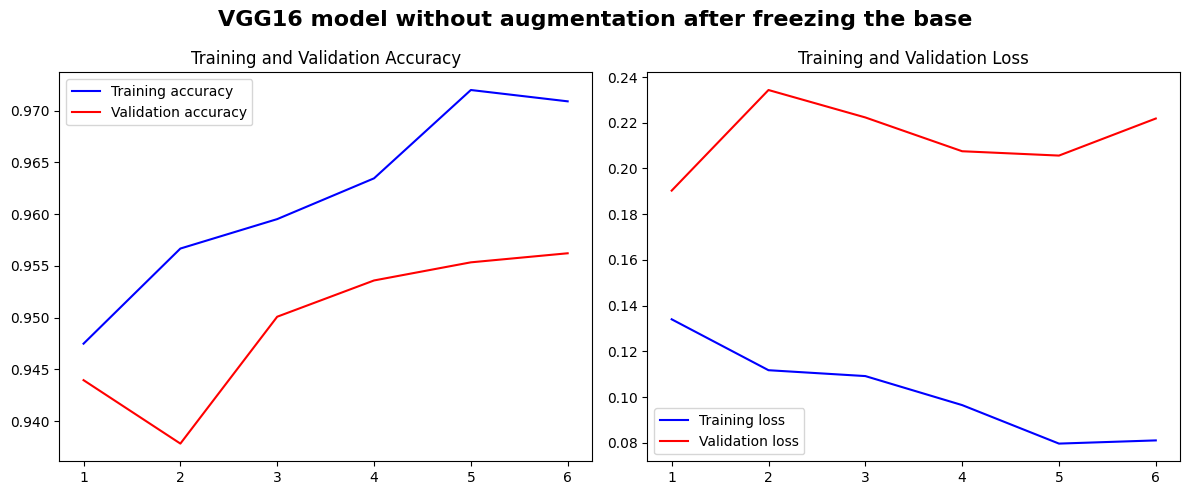

In [ ]:
plot_accuracy_and_loss(history_finetune_vgg, "VGG16 model without augmentation after freezing the base")

In [ ]:
best_vgg = keras.models.load_model('/content/drive/MyDrive/Brain_Tumor_Project/experiments/vgg_model_unfrozen.keras')

In [ ]:
best_vgg.evaluate(test_ds)

41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 472ms/step - accuracy: 0.9200 - loss: 0.3231


[0.23086978495121002, 0.9450801014900208]

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step
              precision    recall  f1-score   support

      glioma       0.96      0.89      0.93       300
  meningioma       0.88      0.89      0.88       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.95      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.95      0.95      0.94      1311



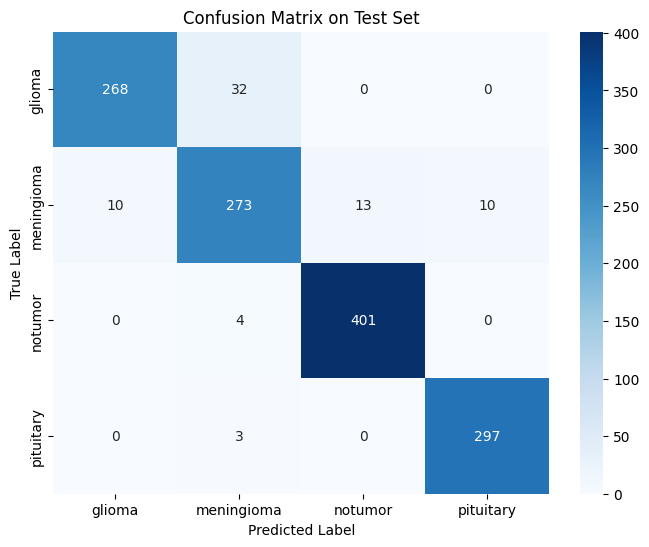

In [ ]:
show_classification_report_confusion_matrix(best_vgg, test_ds, class_names)